# **Visualization of TPM and CO₂ Emissions Over the Amazon**  

This script processes and visualizes **Total Particulate Matter (TPM)** and **Carbon Dioxide (CO₂) emissions** over a defined Amazon region. The emissions are derived from satellite-based data and aggregated on a **0.5° x 0.5° grid**.  

## **Workflow Overview**  

### **1. TPM Daily Emission Calculation**  
- Extracts TPM emission values recorded every **10 minutes**.  
- Aggregates emissions to **daily totals**.  
- Identifies the **day with the highest emission**.  
- Generates a **scatter plot** of daily TPM emissions.  

### **2. Grid-Based TPM and CO₂ Emission Mapping**  
- Loads TPM and CO₂ emissions along with their corresponding **latitude, longitude, and Julian day**.  
- Constructs a **2D grid** using unique latitude and longitude values.  
- Maps emissions onto the grid by summing values per cell for the **day with the highest emissions**.  

### **3. Visualization of Emission Distribution**  
- Uses `matplotlib` to generate two **heatmaps**:  
  - One for **TPM emissions** (Tons).  
  - One for **CO₂ emissions** (Tons).  
- Custom formatting for **latitude and longitude labels**.  
- **Colorbars** with percentile-based scaling for enhanced visualization.  
- Saves the figure as a high-resolution `.png` file.  

## **Technical Details**  
- The emissions are **filtered and aggregated** using NumPy and Pandas.  
- The TPM and CO₂ heatmaps share the same geographical extent.  
- **Custom tick formatters** display lat/lon in degrees North/South and East/West.  
- The final output is saved with a filename that includes the **year of analysis**.  


In [ ]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import math as mt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
from scipy.signal import chirp, find_peaks, peak_widths, find_peaks_cwt
import os
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

In [ ]:
# Define the directory containing the processed emission data files
datadir = '/home/jovyan/Article_review/Emission_processed_data'

# Define the year to process
Year = 2020  
# Example of expected file name format:
# goes_data_emission_rate_amazon_definitive_box_YYYY_150_350.csv
# (where YYYY corresponds to the chosen year)

# Search for all CSV files in the directory matching the specified year
data = sorted(glob.glob(datadir + f'/*goes_data_emission_rate_amazon_definitive_box_{Year}_150_350.csv'))

# Column names available in the dataset:
# sat, year, julian, hhmm, code, central_lat, central_lon, FRP(MW), N_FRP, FRE(MJ), RE(kg/s), ME(kg),
# CO_2(kg), sigma_CO_2(kg), CO(kg), sigma_CO(kg), CH4(kg), sigma_CH4(kg), mean_FRP, mean_temp

# Select relevant columns for analysis
selected_columns = [
    'central_lat', 'central_lon', 'julian', 'ME(kg)', 
    'CO_2(kg)', 'sigma_CO_2(kg)', 'CO(kg)', 'sigma_CO(kg)', 
    'CH4(kg)', 'sigma_CH4(kg)'
]

# Read the first CSV file into a Pandas DataFrame, extracting only the selected columns
emission_data = pd.read_csv(data[0], usecols=selected_columns)


In [ ]:
# Function to plot a graph of the daily emission of TPM (Total Particulate Matter)
def TPM_daily_emission(dt_emission, filename):
    """
    This function calculates and plots the daily TPM (Total Particulate Matter) emissions.
    The emissions are provided in a dataset where each entry corresponds to a 10-minute interval.
    The function sums emissions for each day and generates a time series plot.

    Parameters:
        dt_emission (pd.DataFrame): DataFrame containing the emission data.
        filename (str): Name for the saved plot file.

    Returns:
        int: The Julian day with the highest TPM emission.
    """

    # Extract column names from the dataset
    header = list(dt_emission)

    # Identify the column indices
    pos1 = header.index('julian')  # Julian day column
    pos3 = header.index('ME(kg)')  # TPM emission column

    # Convert data into NumPy arrays, dropping NaN values
    julian = np.array(dt_emission.iloc[:, pos1].dropna(), dtype=pd.Series)
    TPM = np.array(dt_emission.iloc[:, pos3].dropna(), dtype=pd.Series)

    # Prepare the figure layout
    plt.clf()
    plt.title(str(Year))
    plt.ylabel(r'TPM (Tg)')  # Emissions in teragrams
    plt.xlabel('Days of the year')

    # Summing TPM emissions over each day
    days = np.unique(julian)  # Unique Julian days in the dataset
    daily_emissions = []

    for i in range(np.min(days), np.max(days) + 1):
        index = np.where(julian == i)  # Find all entries for a specific day
        daily_sum = np.sum(TPM[index])  # Sum TPM for that day
        daily_emissions = np.append(daily_emissions, daily_sum)

    # Identify the day with the maximum emission
    max_emission_day_index = np.where(daily_emissions == np.max(daily_emissions))
    max_emission_day = days[max_emission_day_index]  # Corresponding Julian day

    # Configure the plot
    plt.ylim(0, np.max(daily_emissions) * 1.1 / 1e9)  # Scale emissions to Tg
    plt.plot(days, daily_emissions / 1e9, 'o', markersize=2, color='black')  # Scatter plot

    # Display total emission in legend
    total_emission_text = 'Total\nemission: {:.2e} Tg'.format(np.sum(TPM[TPM > 0]) * 1e-9)
    plt.legend([total_emission_text], loc='best')

    # Save the plot as an image file
    plt.savefig(filename + '.png', dpi=200)

    # Return the Julian day with the highest emission (to be used in other functions)
    return max_emission_day[0]


In [ ]:
day_emission_max = TPM_daily_emission(emission_data,'TPM_emission_distribuition_amazon_definitive_box_'+str(Year))
filename = 'TPM_and_C02_emission_mapping_amazon_definitive_box_'+str(Year)+'_total'
#day_emission_max = 247
#Function to plot the daily(max emission day) emission of TPM and CO2 on a grid
#The grid cell has a 0.5°x0.5° of area
#The region of the grid was determined on previous codes that delimited the Amazon region of interest

#List the data file header
header = list(emission_data)

#Extract the columns of the file
pos1 = header.index('julian')
column1 = emission_data.iloc[:, pos1]
julian = np.array(column1.dropna(), dtype=pd.Series)

pos3 = header.index('ME(kg)')
column3 = emission_data.iloc[:, pos3]
TPM = np.array(column3.dropna(), dtype=pd.Series)

pos2 = header.index('central_lat')
column2 = emission_data.iloc[:, pos2]
lat = np.array(column2.dropna(), dtype=pd.Series)

pos4 = header.index('central_lon')
column4 = emission_data.iloc[:, pos4]
lon = np.array(column4.dropna(), dtype=pd.Series)

pos3 = header.index('CO_2(kg)')
column3 = emission_data.iloc[:, pos3]
CO2 = np.array(column3.dropna(), dtype=pd.Series)

#Extract the lats and lons of the region without repetions
lats = np.unique(lat)
lons = np.unique(lon)
lats = lats[::-1] #It is necessary to invert the order of the latitudes

#Configure the matrices based on the lats and lons
matrix_TPM = np.zeros((len(lats), len(lons)), dtype='float64')
matrix_CO2 = np.zeros((len(lats), len(lons)), dtype='float64')

#Loop through the lats and lons, for each lat, lon and day(in this case only the max emission day)
#save on the cell of the matrices the emission that correspond to each lat and lon
for k in range(0, len(lats)):
    Progress = 'Progress: {:.1f}lat/{:.1f}lats'.format(k, len(lats))
    print(Progress)
    for n in range(0, len(lons)):
        index = np.where((lat == lats[k]) & (lon == lons[n]) & (julian == day_emission_max))
        matrix_TPM[k, n] = np.sum(TPM[index])*1e-3
        matrix_CO2[k, n] = np.sum(CO2[index])*1e-3

In [ ]:
# Function to format latitude
def format_latitude(y, _):
    direction = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{direction}"

# Function to format longitude
def format_longitude(x, _):
    direction = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{direction}"

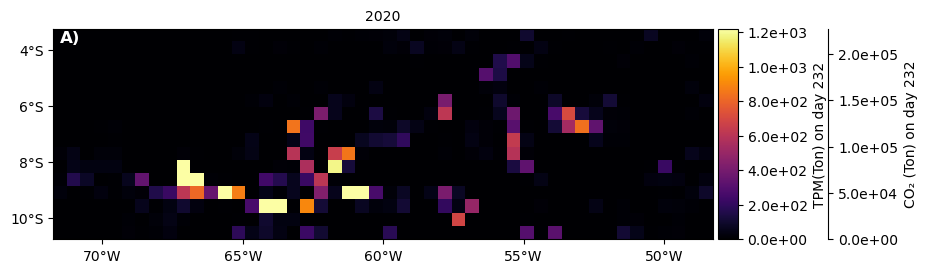

In [37]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 3))

# Define plot extent
extent = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]

# Compute percentile-based min/max for better visualization
vmin_tpm, vmax_tpm = np.percentile(matrix_TPM, [30, 99])
vmin_co2, vmax_co2 = np.percentile(matrix_CO2, [30, 99])

# TPM and CO2 Plot
im = ax.imshow(matrix_TPM, cmap='inferno', extent=extent,vmin=vmin_tpm,vmax=vmax_tpm)
im2 = ax.imshow(matrix_CO2, cmap='inferno', extent=extent,vmin=vmin_co2,vmax=vmax_co2)
ax.set_title(str(Year), fontsize=10)

# Set tick formatters
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_longitude))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_latitude))

# Bold annotation in upper-left corner
ax.text(
    0.01, 0.99,               # Coordinates (relative to axes: 0=left/bottom, 1=right/top)
    'A)',        # Text content
    transform=ax.transAxes,   # Use axes-relative coordinates
    fontsize=12,              # Font size
    fontweight='bold',
    color = 'white', # Bold text
    ha='left',                # Horizontal alignment
    va='top',                 # Vertical alignment
)

# Create colorbars
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.05)
cb1 = plt.colorbar(im, cax=cax1, format='%.1e')
cb1.set_label("TPM(Ton) on day {:.0f}".format(day_emission_max), fontsize=10)

cax2 = divider.append_axes("right", size="0.05%", pad=0.90)
cb2 = plt.colorbar(im2, cax=cax2, format='%.1e')
cb2.set_label("CO₂ (Ton) on day {:.0f}".format(day_emission_max), fontsize=10)

# Save figure
#plt.savefig(filename + '.png', dpi=300)
plt.show()